In [20]:
#
# This is an example from jbr Reactor Design Book
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
#

Reduced order model with states $V, \epsilon_2$:
$$\frac{dV}{dt} = Q^{in}_B(t)$$
$$\frac{d\epsilon_2}{dt} = \frac{Q^{in}_B(t)c_{Bf}(n^{added}_B-2\epsilon_2)}{(n^{added}_B-2\epsilon_2) + k(n_{A0} - n^{added}_B + \epsilon_2)} $$ 

Calculation of $n_B^{added}$:
$$ n_B^{added} = (V - V(0))c_{Bf} $$

Parameters:
$k = 2.48, \;\;n_{A0} = 2.35$

Initial conditions:
$V = 2370, \;\;\epsilon_2 = 0$

When I just used $V, \epsilon_2$ as state variables, kipet had trouble even simulating the system. So I rewrote the system with auxiliary algebraic variables which simulated without a problem.

$$\frac{dV}{dt} = Q^{in}_B(t)$$
$$\frac{d\epsilon_2}{dt} = y_1(t) $$ 
$$ y_1(t)[(n^{added}_B-2\epsilon_2) + k(n_{A0} - n^{added}_B + \epsilon_2)] = Q^{in}_B(t)c_{Bf}(n^{added}_B-2\epsilon_2) $$
$$ n_B^{added} = (V - V(0))c_{Bf} $$

While this simulated without issues, I am having trouble doing parameter estimation of $k$ and $n_{A0}$

In [21]:
from kipet import KipetModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

In [22]:
# Import data set with flow of B over time
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/flow.dat'
flow_df = pd.read_csv(filename, delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['qin_B'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')
qinB_traj = flow_df[['qin_B']]
qinB_traj

,qin_B
time,
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319
49.0,1.669967
...,...
829.0,0.000990
839.0,0.000782
849.0,0.000643


In [23]:
# insert first row for time 0
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [28]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/lc.dat'
lc_data = pd.read_csv(filename, delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [29]:
#lc_data_0 = pd.DataFrame({'time':qinB_traj.index[qinB_traj.index < 414]})
#lc_data_0['y'] = 1
#lc_data_0 = lc_data_0.set_index('time')
lc_data_0 = pd.DataFrame({'time':[0], 'y':[0]}).set_index('time')
lc_data = pd.concat([lc_data_0, lc_data])

In [30]:
lc_data.head()

,y
time,
0,0.0000
414,0.1705
424,0.1604
434,0.1325
444,0.1084


In [73]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('V', state = 'state', init = 2370)
r1.add_component('eps2', state = 'concentration', init = 0.0)
#r1.add_component('qin_B', state = 'trajectory')

r1.add_algebraic_variables('qin_B')
r1.add_algebraic_variables('nBadded')
r1.add_algebraic_variables('y1', init = 0.0)
r1.add_algebraic_variables('y', init = 1e-6, bounds = (0.0, 1.0))

r1.add_parameter('k', init = 2.48, bounds = (1e-6, 10))
r1.add_parameter('na0', init = 2.34, bounds = (1,3))

cbf = 0.00721
V0 = 2370

In [74]:
def rule_odes(m,t):
        
    exprs = dict()
    exprs['V'] = m.Y[t,'qin_B']
    exprs['eps2'] = m.Y[t, 'y1']
    return exprs

r1.add_equations(rule_odes) 

In [75]:
def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t,'nBadded'] - (m.X[t, 'V'] - V0) * cbf)
    r.append(m.Y[t,'y1'] * ((m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']) + m.P['k']*(m.P['na0'] - m.Y[t,'nBadded'] + m.Z[t, 'eps2'])) - m.Y[t,'qin_B'] * cbf * (m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']))
    r.append(m.Y[t, 'y'] * m.Y[t, 'nBadded'] - (m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']))
    return r

r1.add_algebraics(rule_algebraics)

In [76]:
r1.add_objective_from_algebraic('y')

In [77]:
r1.add_dataset('lc_data', category = 'custom', data = lc_data)
r1.add_dataset('Traj', category = 'trajectory', data = qinB_traj)

In [78]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 900)

In [79]:
r1.settings.collocation.nfe = 60
r1.settings.collocation.ncp = 1
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.solver.linear_solver = 'ma27'
r1.settings.parameter_estimator['solver'] = 'k_aug'

In [80]:
r1.create_pyomo_model()

times are: <class 'tuple'>
0 900
 If this is the desired behavior, some algebraics must be added after the model is created.


In [81]:
r1.run_opt()

No variance information for V found, setting equal to unity
No variance information for eps2 found, setting equal to unity
        0.05 seconds required to write file
        0.05 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     1152
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      464

Total number of variables............................:      427
                     variables with only lower bounds:        0
      

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 427
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 425
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 2
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601035646951091 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.563643497384918 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 425, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 1152
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 464
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 1.000338
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 391
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...


RESULTS
Z:
                   eps2
0.0000   -1.195277e-65
12.9375   8.429578e-04
25.8750   7.018275e-03
38.8125   1.728100e-02
51.7500   3.144532e-02
...                ...
848.0000  2.095785e+00
858.0000  2.095835e+00
868.0000  2.095878e+00
884.0000  2.095947e+00
900.0000  2.096016e+00

[61 rows x 1 columns]

X:
                     V
0.0000    2370.000000
12.9375   2380.084785
25.8750   2402.680509
38.8125   2424.724779
51.7500   2446.190304
...               ...
848.0000  2975.807118
858.0000  2975.814171
868.0000  2975.820356
884.0000  2975.830085
900.0000  2975.839814

[61 rows x 1 columns]

dZdt:
               eps2
0.0000    0.000000
12.9375   0.000065
25.8750   0.000477
38.8125   0.000793
51.7500   0.001095
...            ...
848.0000  0.000005
858.0000  0.000005
868.0000  0.000004
884.0000  0.000004
900.0000  0.000004

[61 rows x 1 columns]

dXdt:
                  V
0.0000    0.000000
12.9375   0.779500
25.8750   1.746529
38.8125   1.703905
51.7500   1.659171
...            

In [82]:
r1.results.show_parameters


The estimated parameters are:
k 2.750504192253101
na0 2.2734412171117184


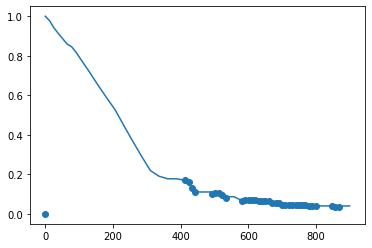

In [83]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(r1.results.Y.index, r1.results.Y['y'])

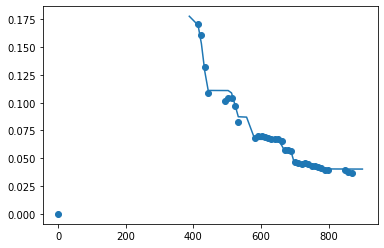

In [84]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(r1.results.Y.index[r1.results.Y.index >= 380], r1.results.Y['y'][r1.results.Y.index >= 380])

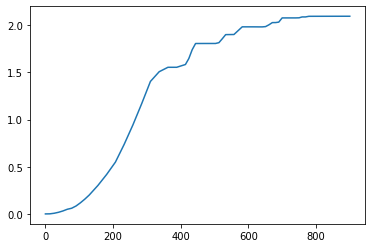

In [85]:
fig, ax = plt.subplots()
ax.plot(r1.results.Z.index, r1.results.Z['eps2'])

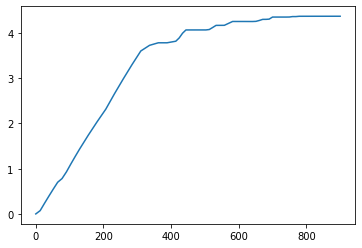

In [86]:
fig, ax = plt.subplots()
ax.plot(r1.results.Y.index, r1.results.Y['nBadded'])

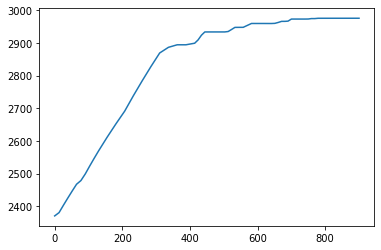

In [87]:
fig, ax = plt.subplots()
ax.plot(r1.results.X.index, r1.results.X['V'])

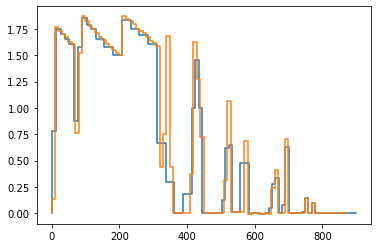

In [88]:
fig, ax = plt.subplots()
ax.step(r1.results.Y.index, r1.results.Y['qin_B'])
ax.step(qinB_traj.index, qinB_traj['qin_B'])

In [89]:
dof = lc_data.shape[0] - 3
mse = r1.results.objective / dof
cov_mat = 2 * mse * r1.results.parameter_covariance
cov_mat

array([[ 5.96626715e+01, -5.10144674e-01],
       [-5.10144674e-01,  8.89859311e-03]])

In [90]:
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_mat))
conf_delta

array([15.71492481,  0.19192062])